## Assessment of study-dataset splitting

<b>source:</b> "https://github.com/LungCellAtlas/HLCA_reproducibility/blob/main/notebooks/1_building_and_annotating_the_atlas_core/01b_study_splitting_by_batch_effect_assessment.ipynb"

In this notebook we will determine which of the studies that have substantial differences in experimental conditions within study will need to be split into separate datasets (datasets will be the "batches" used for integration).

### Import modules

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tqdm.autonotebook import tqdm as tqdm

/tmp/ipykernel_2274547/364988672.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm as tqdm


In [2]:
def check_if_nan(value):
    """return Boolean version of value that is True if value is
    some type of NaN (e.g. np.nan, None, "nan" etc). 
    Example use:
    none_entries = subadata.obs.applymap(check_if_nan)
    subadata.obs = subadata.obs.mask(none_entries.values)
    """
    if value == "nan":
        return True
    elif value == None:
        return True
    if isinstance(value, float):
        if np.isnan(value):
            return True
    if value == "ND":
        return True
    return False

### Set paths:

In [3]:
# path of partly preprocessed HLCA file used in this notebook:
adata_path = "/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/all_datasets_merged/complete_merged_public_and_galapagos_harmonized.h5ad"
# path to results directory:
dir_out = "/home/icb/lea.hollenberg/masterpraktikum_fibrosis_atlas/notebooks/batch_effect_analysis/"

### Perpare groups to check batch effect

In [4]:
adata = sc.read(adata_path)

In [5]:
adata.obs

,author_annotation,manual_celltype_annotation,batch,condition,timepoint,dataset,fibrotic/control,coarse_harmonized_anno,Phase,SAMP_stage,...,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,celltypist_group,harmonized_anno
AAACCTGAGGACATTA-1_xie,Col13a1,Myofibroblasts,1_xie,untreated,NaN,xie,control,Myofibroblasts,NaN,NaN,...,1223,7.109879,2549.0,7.843849,26.794821,194.0,5.273000,7.610828,Group3,Fibroblasts
AAACCTGCAGTCGTGC-1_xie,Myofibroblasts,Peribronchial fibroblasts,1_xie,untreated,NaN,xie,control,Fibroblasts,NaN,NaN,...,1186,7.079184,2271.0,7.728416,23.029502,48.0,3.891820,2.113606,Group2,Peribronchial fibroblasts
AAACCTGCATGAAGTA-1_xie,Lipofibroblasts,Alveolar macrophages,1_xie,untreated,NaN,xie,control,Alveolar macrophages,NaN,NaN,...,885,6.786717,1642.0,7.404279,19.975639,22.0,3.135494,1.339829,Group17,Alveolar macrophages
AAACCTGTCTCGCATC-1_xie,Myofibroblasts,Peribronchial fibroblasts,1_xie,untreated,NaN,xie,control,Fibroblasts,NaN,NaN,...,680,6.523562,1196.0,7.087574,28.428094,15.0,2.772589,1.254181,Group2,Peribronchial fibroblasts
AAACGGGTCCTAGAAC-1_xie,Myofibroblasts,Peribronchial fibroblasts,1_xie,untreated,NaN,xie,control,Fibroblasts,NaN,NaN,...,595,6.390241,944.0,6.851185,27.648305,21.0,3.091042,2.224576,Group2,Peribronchial fibroblasts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343066_galapagos_rad,NaN,Alveolar macrophages,74.0_galapagos_rad,radiation,NaN,galapagos_rad,fibrotic,NaN,S,19weeks,...,5055,8.528331,20895.0,9.947313,18.315386,1538.0,7.338888,7.360613,Group17,Alveolar macrophages
343067_galapagos_rad,NaN,AT2,74.0_galapagos_rad,radiation,NaN,galapagos_rad,fibrotic,NaN,G1,19weeks,...,4981,8.513587,25350.0,10.140573,30.954635,834.0,6.727432,3.289941,Group7,AT2
343068_galapagos_rad,NaN,B-cells,74.0_galapagos_rad,radiation,NaN,galapagos_rad,fibrotic,NaN,G2M,19weeks,...,812,6.700731,1846.0,7.521318,21.885157,114.0,4.744932,6.175515,Group15,B-cells
343069_galapagos_rad,NaN,B-cells,74.0_galapagos_rad,radiation,NaN,galapagos_rad,fibrotic,NaN,G2M,19weeks,...,562,6.333280,1487.0,7.305188,27.505044,105.0,4.663439,7.061197,Group15,B-cells


In [7]:
adata

AnnData object with n_obs × n_vars = 535908 × 28090
    obs: 'author_annotation', 'manual_celltype_annotation', 'batch', 'condition', 'timepoint', 'dataset', 'fibrotic/control', 'coarse_harmonized_anno', 'Phase', 'SAMP_stage', 'SC_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_group', 'harmonized_anno'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dataset_colors', 'hvg', 'manual_celltype_annotation_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

specifiy covariates we want to check (we will quantify their correlation with the 1st 50 PCs, to see how much variance they can each explain):

In [8]:
covariates = [
    "dataset", 
    "batch",
    "condition",
    "fibrotic/control",
    "harmonized_anno"
]

Create shuffled assignment of single cell platform (and processing site if included), to compare actual variance explained to variance explained expected by random. We will assign all cells of the same sample to the same value.

In [9]:
# create shuffled version of single cell platform, and of Processing_site:
sample_to_covariate = pd.DataFrame()
covariates_to_shuffle = [
    "dataset", 
    #"batch",
    "condition",
    "fibrotic/control",
    "harmonized_anno"
]

for group in covariates_to_shuffle:
    sample_to_covariate[group] = adata.obs.groupby("batch").agg({group: "first"})
    
    for i in range(10):
        np.random.shuffle(sample_to_covariate[group])
        adata.obs["shuffled_"+ group + str(i)] = adata.obs["batch"].map(
            dict(
                zip(
                    sample_to_covariate.index,
                    sample_to_covariate[group],
                )
            )
        )
        covariates.append("shuffled_"+ group + str(i))

print(covariates)
sample_to_covariate

/tmp/ipykernel_2274547/424203198.py:15: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(sample_to_covariate[group])
/tmp/ipykernel_2274547/424203198.py:15: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(sample_to_covariate[group])
/tmp/ipykernel_2274547/424203198.py:15: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(sample_to_covariate[group])
/tmp/ipykernel_2274547/424203198.p

['dataset', 'batch', 'condition', 'fibrotic/control', 'harmonized_anno', 'shuffled_dataset0', 'shuffled_dataset1', 'shuffled_dataset2', 'shuffled_dataset3', 'shuffled_dataset4', 'shuffled_dataset5', 'shuffled_dataset6', 'shuffled_dataset7', 'shuffled_dataset8', 'shuffled_dataset9', 'shuffled_condition0', 'shuffled_condition1', 'shuffled_condition2', 'shuffled_condition3', 'shuffled_condition4', 'shuffled_condition5', 'shuffled_condition6', 'shuffled_condition7', 'shuffled_condition8', 'shuffled_condition9', 'shuffled_fibrotic/control0', 'shuffled_fibrotic/control1', 'shuffled_fibrotic/control2', 'shuffled_fibrotic/control3', 'shuffled_fibrotic/control4', 'shuffled_fibrotic/control5', 'shuffled_fibrotic/control6', 'shuffled_fibrotic/control7', 'shuffled_fibrotic/control8', 'shuffled_fibrotic/control9', 'shuffled_harmonized_anno0', 'shuffled_harmonized_anno1', 'shuffled_harmonized_anno2', 'shuffled_harmonized_anno3', 'shuffled_harmonized_anno4', 'shuffled_harmonized_anno5', 'shuffled_har

,dataset,condition,fibrotic/control,harmonized_anno
batch,,,,
0_misharin,galapagos_rad,untreated,fibrotic,Endothelial
0_tsukui,galapagos_rad,bleomycin,control,Transitioning epithelial
1.0_galapagos_bleo,peyser,untreated,control,Endothelial
1.0_galapagos_rad,galapagos_bleo,radiation,control,Dendritic cells
10.0_galapagos_rad,galapagos_bleo,radiation,fibrotic,Dendritic cells
...,...,...,...,...
muc4649_schiller,galapagos_rad,radiation,fibrotic,Dendritic cells
muc4653_schiller,peyser,radiation,fibrotic,B-cells
muc4655_schiller,galapagos_rad,bleomycin,fibrotic,B-cells


In [10]:
covariates

['dataset',
 'batch',
 'condition',
 'fibrotic/control',
 'harmonized_anno',
 'shuffled_dataset0',
 'shuffled_dataset1',
 'shuffled_dataset2',
 'shuffled_dataset3',
 'shuffled_dataset4',
 'shuffled_dataset5',
 'shuffled_dataset6',
 'shuffled_dataset7',
 'shuffled_dataset8',
 'shuffled_dataset9',
 'shuffled_condition0',
 'shuffled_condition1',
 'shuffled_condition2',
 'shuffled_condition3',
 'shuffled_condition4',
 'shuffled_condition5',
 'shuffled_condition6',
 'shuffled_condition7',
 'shuffled_condition8',
 'shuffled_condition9',
 'shuffled_fibrotic/control0',
 'shuffled_fibrotic/control1',
 'shuffled_fibrotic/control2',
 'shuffled_fibrotic/control3',
 'shuffled_fibrotic/control4',
 'shuffled_fibrotic/control5',
 'shuffled_fibrotic/control6',
 'shuffled_fibrotic/control7',
 'shuffled_fibrotic/control8',
 'shuffled_fibrotic/control9',
 'shuffled_harmonized_anno0',
 'shuffled_harmonized_anno1',
 'shuffled_harmonized_anno2',
 'shuffled_harmonized_anno3',
 'shuffled_harmonized_anno4',
 's

In [11]:
adata.obs

,author_annotation,manual_celltype_annotation,batch,condition,timepoint,dataset,fibrotic/control,coarse_harmonized_anno,Phase,SAMP_stage,...,shuffled_harmonized_anno0,shuffled_harmonized_anno1,shuffled_harmonized_anno2,shuffled_harmonized_anno3,shuffled_harmonized_anno4,shuffled_harmonized_anno5,shuffled_harmonized_anno6,shuffled_harmonized_anno7,shuffled_harmonized_anno8,shuffled_harmonized_anno9
AAACCTGAGGACATTA-1_xie,Col13a1,Myofibroblasts,1_xie,untreated,NaN,xie,control,Myofibroblasts,NaN,NaN,...,B-cells,Dendritic cells,Epithelial,Dendritic cells,AT1/2,CD8 T-cells,B-cells,NK cells,Neutrophils,T-cells
AAACCTGCAGTCGTGC-1_xie,Myofibroblasts,Peribronchial fibroblasts,1_xie,untreated,NaN,xie,control,Fibroblasts,NaN,NaN,...,B-cells,Dendritic cells,Epithelial,Dendritic cells,AT1/2,CD8 T-cells,B-cells,NK cells,Neutrophils,T-cells
AAACCTGCATGAAGTA-1_xie,Lipofibroblasts,Alveolar macrophages,1_xie,untreated,NaN,xie,control,Alveolar macrophages,NaN,NaN,...,B-cells,Dendritic cells,Epithelial,Dendritic cells,AT1/2,CD8 T-cells,B-cells,NK cells,Neutrophils,T-cells
AAACCTGTCTCGCATC-1_xie,Myofibroblasts,Peribronchial fibroblasts,1_xie,untreated,NaN,xie,control,Fibroblasts,NaN,NaN,...,B-cells,Dendritic cells,Epithelial,Dendritic cells,AT1/2,CD8 T-cells,B-cells,NK cells,Neutrophils,T-cells
AAACGGGTCCTAGAAC-1_xie,Myofibroblasts,Peribronchial fibroblasts,1_xie,untreated,NaN,xie,control,Fibroblasts,NaN,NaN,...,B-cells,Dendritic cells,Epithelial,Dendritic cells,AT1/2,CD8 T-cells,B-cells,NK cells,Neutrophils,T-cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343066_galapagos_rad,NaN,Alveolar macrophages,74.0_galapagos_rad,radiation,NaN,galapagos_rad,fibrotic,NaN,S,19weeks,...,B-cells,T-cells,Non-classical monocytes,CD8 T-cells,CD8 T-cells,AT1,Dendritic cells,Regulatory T-cells,B-cells,Interstitial macrophages
343067_galapagos_rad,NaN,AT2,74.0_galapagos_rad,radiation,NaN,galapagos_rad,fibrotic,NaN,G1,19weeks,...,B-cells,T-cells,Non-classical monocytes,CD8 T-cells,CD8 T-cells,AT1,Dendritic cells,Regulatory T-cells,B-cells,Interstitial macrophages
343068_galapagos_rad,NaN,B-cells,74.0_galapagos_rad,radiation,NaN,galapagos_rad,fibrotic,NaN,G2M,19weeks,...,B-cells,T-cells,Non-classical monocytes,CD8 T-cells,CD8 T-cells,AT1,Dendritic cells,Regulatory T-cells,B-cells,Interstitial macrophages
343069_galapagos_rad,NaN,B-cells,74.0_galapagos_rad,radiation,NaN,galapagos_rad,fibrotic,NaN,G2M,19weeks,...,B-cells,T-cells,Non-classical monocytes,CD8 T-cells,CD8 T-cells,AT1,Dendritic cells,Regulatory T-cells,B-cells,Interstitial macrophages


In [12]:
n_pcs = 50

Now check for every covariate, for every PC how much variance among the cells' PC scores the covariate can explain. Add this variance explained per PC up across PCs for every covariate. This will give us the total amount of variance explained per covariate.

In [13]:
var_explained = pd.DataFrame(index=range(n_pcs), columns=covariates + ["overall"])
for pc in tqdm(range(n_pcs)):
    y_true_unfiltered = adata.obsm["X_pca"][:, pc]
    var_explained.loc[pc, "overall"] = np.var(y_true_unfiltered)
    for cov in covariates:
        x = adata.obs[cov].values.copy()
        x_nans = np.vectorize(check_if_nan)(x)
        x = x[~x_nans]
        if len(x) != 0:
            y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
            if x.dtype in ["float32", "float", "float64"]:
                x = x.reshape(-1, 1)
            else:
                if len(set(x)) == 1:
                    var_explained.loc[pc, cov] = np.nan
                    continue
                x = pd.get_dummies(x)
            lrf = LinearRegression(fit_intercept=True).fit(
                x,
                y_true,
            )
            y_pred = lrf.predict(x)
            var_explained.loc[pc, cov] = np.var(y_pred)
total_variance_explained = np.sum(var_explained, axis=0).sort_values(ascending=False)
total_variance_explained_fractions = (
    total_variance_explained / total_variance_explained["overall"]
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [16:23<00:00, 19.67s/it]


In [14]:
var_explained

,dataset,batch,condition,fibrotic/control,harmonized_anno,shuffled_dataset0,shuffled_dataset1,shuffled_dataset2,shuffled_dataset3,shuffled_dataset4,...,shuffled_harmonized_anno1,shuffled_harmonized_anno2,shuffled_harmonized_anno3,shuffled_harmonized_anno4,shuffled_harmonized_anno5,shuffled_harmonized_anno6,shuffled_harmonized_anno7,shuffled_harmonized_anno8,shuffled_harmonized_anno9,overall
0,361.342874,460.720339,264.41069,7.016155,1630.110647,3.760213,16.727613,15.490567,81.205813,11.843551,...,55.06886,39.748421,36.213759,78.891193,106.818177,182.523812,60.849423,117.084392,32.354289,50932.585938
1,712.239348,2001.651519,863.289539,278.201034,16015.436995,47.792366,86.167951,66.469422,122.803357,42.505686,...,208.663682,527.881493,316.339632,286.899897,620.321315,359.159936,398.458151,251.076408,221.768473,25918.085938
2,44.554244,84.855346,6.161236,0.352555,378.034687,0.891477,1.873257,0.898369,2.396446,3.141345,...,7.519788,9.392959,7.440332,10.141845,6.168439,8.649477,9.265115,14.368866,3.113337,12635.438477
3,187.107773,364.361492,140.988148,26.098615,5237.760995,11.523242,5.902104,13.431263,9.887417,5.651188,...,45.529202,70.101,41.751845,65.166316,39.538087,60.058017,59.095368,55.045301,68.905336,9856.28418
4,5.779035,68.892867,1.0649,0.576923,4128.908128,2.402309,2.153757,2.516816,3.645363,1.581173,...,4.900507,7.273608,12.104749,11.068214,4.367312,5.831469,6.07794,4.839331,11.192468,7448.349609
5,166.209414,509.857009,59.689035,0.015222,2575.24537,7.277281,16.845471,14.671697,23.519248,23.076746,...,44.530892,24.4766,63.012844,32.838118,49.539556,30.35173,41.975972,24.514913,26.016434,6689.913086
6,30.760251,265.067443,76.462155,66.812455,545.375073,13.175132,10.947693,19.158497,10.311623,3.836233,...,56.795264,26.827099,24.604482,33.254007,75.607407,25.746344,31.443863,32.503909,30.964757,5901.270996
7,34.387204,109.871139,15.844137,10.664795,1837.672798,1.319435,1.032264,7.885458,2.6985,1.369426,...,5.638686,28.123077,9.199427,23.132629,30.215459,7.356304,7.7893,8.009361,14.921033,4811.93457
8,113.952205,249.170817,4.732907,0.308255,1557.723759,6.451653,5.494709,7.381225,3.41058,7.68073,...,28.513184,38.19665,21.114554,15.67505,29.786449,28.495453,27.803512,28.574761,29.861235,4488.154297
9,65.911086,137.470799,12.205554,0.101794,86.610981,0.736003,2.322251,5.134871,4.033315,2.367414,...,8.398793,22.679121,9.419017,22.860931,66.881928,7.856498,16.575707,12.415451,7.575408,2690.832764


In [15]:
total_variance_explained_clean = total_variance_explained_fractions[
    [
        x
        for x in total_variance_explained_fractions.index
        if not x.startswith("shuffled_")
    ]
]
total_variance_explained_clean = total_variance_explained_clean[1:]
total_variance_explained_clean

harmonized_anno     0.253771
batch                0.03242
dataset             0.013452
condition           0.010492
fibrotic/control    0.002765
dtype: object

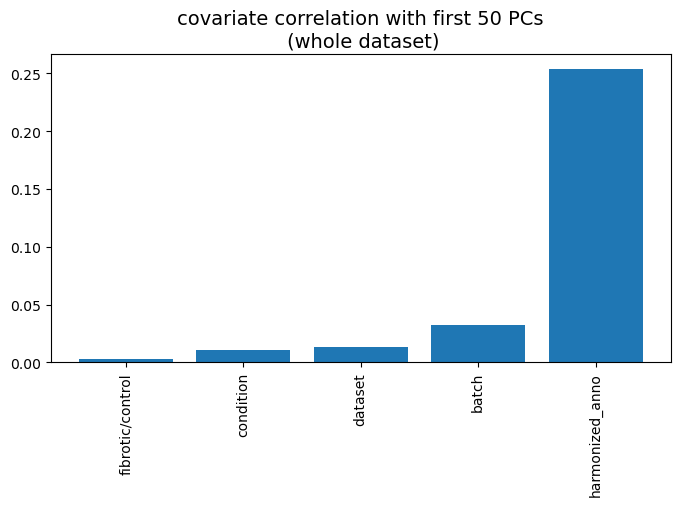

In [16]:
plt.figure(figsize=(8, 4))
plt.bar(
    total_variance_explained_clean[::-1].index,
    total_variance_explained_clean[::-1].values,
)
plt.title(
    "covariate correlation with first 50 PCs\n (whole dataset)",
    fontsize=14,
) 
plt.xticks(rotation=90)
plt.show()

The greatest effect can be seen within the cell types. This effect is a biological effect that we do not want to correct.
In order to be able to compare the other groupings better, the values in connection with the annotation of the cell types are removed. 

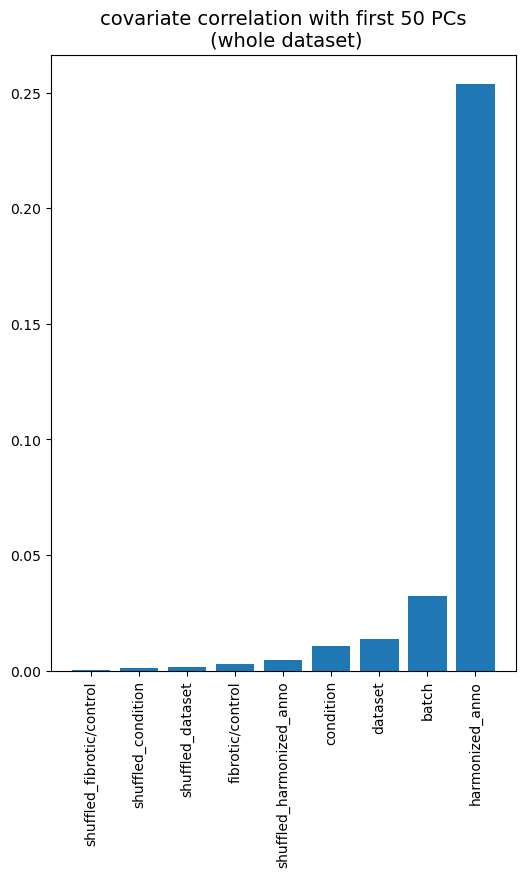

In [65]:
total_variance_explained_clean_without_annotation = total_variance_explained_clean#[1:]
plt.figure(figsize=(6, 8))
plt.bar(
    total_variance_explained_clean_without_annotation[::-1].index,
    total_variance_explained_clean_without_annotation[::-1].values,
)
plt.title(
    "covariate correlation with first 50 PCs\n (whole dataset)",
    fontsize=14,
)  # \n({dominant_type})
plt.xticks(rotation=90)
plt.savefig(f"{dir_out}/results_integrated/batch_effect_plot.png", )

## Compare the effects with the effects visible in a shuffled annotation 

In [24]:
groups = [
    "dataset", 
    #"batch",
    "condition",
    "fibrotic/control",
    "harmonized_anno"
]

stdev_single_cell_platform_shuffled = {}
for group in groups:
    total_variance_explained_clean[f"shuffled_{group}"] = np.mean(
        total_variance_explained_fractions[
            [
                x
                for x in total_variance_explained_fractions.index
                if x.startswith(f"shuffled_{group}")
            ]
        ]
    )
    
    stdev_single_cell_platform_shuffled[f"shuffled_{group}"] = np.std(
        total_variance_explained_fractions[
            [
                x
                for x in total_variance_explained_fractions.index
                if x.startswith(f"shuffled_{group}")
            ]
        ]
    )
    
stdev_single_cell_platform_shuffled

{'shuffled_dataset': 0.0004448829266407713,
 'shuffled_condition': 0.0005730779613058412,
 'shuffled_fibrotic/control': 0.0001803547969144379,
 'shuffled_harmonized_anno': 0.0011457641291768835}

In [25]:
total_variance_explained_clean.sort_values(ascending=False, inplace=True)

In [26]:
total_variance_explained_clean

harmonized_anno              0.253771
batch                         0.03242
dataset                      0.013452
condition                    0.010492
shuffled_harmonized_anno     0.004735
fibrotic/control             0.002765
shuffled_dataset             0.001354
shuffled_condition           0.000975
shuffled_fibrotic/control    0.000198
dtype: object

Plot:

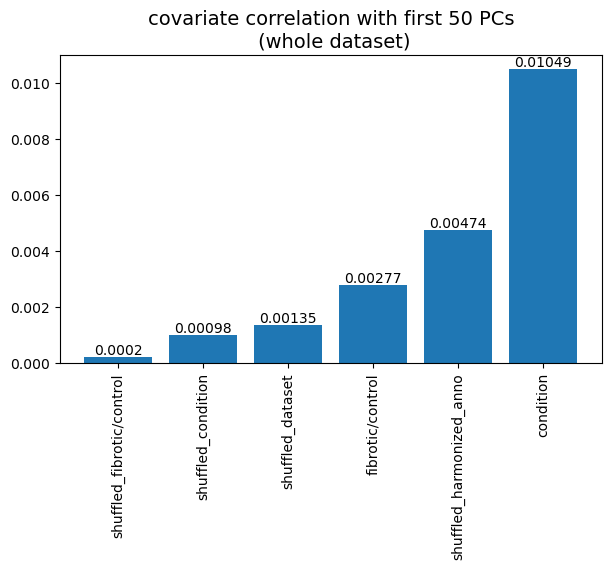

In [27]:
total_variance_explained_clean_without_annotation = total_variance_explained_clean[3:]

plt.figure(figsize=(7, 4))
rounded_values = total_variance_explained_clean_without_annotation[::-1].values.astype('float').round(5)
plt.bar(
    total_variance_explained_clean_without_annotation[::-1].index,
    rounded_values,
)

# Add rounded numbers on top of the bars
for i, value in enumerate(rounded_values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.title(
    "covariate correlation with first 50 PCs\n (whole dataset)",
    fontsize=14,
)
plt.xticks(rotation=90)
plt.show()


### Store results:

In [29]:
res = pd.DataFrame(total_variance_explained_clean)
res.columns = ["fraction_of_variance_explained"]
for group in groups:
    res.loc[f"shuffled_{group}", "stdev"] = stdev_single_cell_platform_shuffled[f"shuffled_{group}"]

res

,fraction_of_variance_explained,stdev
harmonized_anno,0.253771,NaN
batch,0.03242,NaN
dataset,0.013452,NaN
condition,0.010492,NaN
shuffled_harmonized_anno,0.004735,0.001146
fibrotic/control,0.002765,NaN
shuffled_dataset,0.001354,0.000445
shuffled_condition,0.000975,0.000573
shuffled_fibrotic/control,0.000198,0.000180


In [30]:
res.to_csv(
    f"{dir_out}/variance_explained_per_covariate.csv"
)

print z-score:

In [31]:
for group in groups:
    print(group)
    print(
        (res.loc[group, "fraction_of_variance_explained"]
        - res.loc[f"shuffled_{group}", "fraction_of_variance_explained"]
        ) / res.loc[f"shuffled_{group}", "stdev"]

    )

dataset
27.194001472734936
condition
16.605527536012303
fibrotic/control
14.238036025047254
harmonized_anno
217.3529429523426


In [84]:
# final plot for the report 
df = pd.read_csv(f"{dir_out}/results_integrated/variance_explained_per_covariate.csv")
df.rename(columns={'Unnamed: 0': 'groupings'}, inplace=True)

#sortierung = ['batch', 'dataset', 'shuffled_dataset', 'condition', 'shuffled_condition', 
#              'fibrotic/control', 'shuffled_fibrotic/control']

# change fibrotic/control to label
df.loc[df['groupings'] == 'fibrotic/control', 'groupings'] =  "label"
df.loc[df['groupings'] == 'shuffled_fibrotic/control', 'groupings'] =  "shuffled_label"

df


,groupings,fraction_of_variance_explained,stdev
0,harmonized_anno,0.253771,NaN
1,batch,0.032420,NaN
2,dataset,0.013452,NaN
3,condition,0.010492,NaN
4,shuffled_harmonized_anno,0.004735,0.001146
5,label,0.002765,NaN
6,shuffled_dataset,0.001354,0.000445
7,shuffled_condition,0.000975,0.000573
8,shuffled_label,0.000198,0.000180


In [85]:
sortierung = ['shuffled_label', 'label', 'shuffled_condition', 'condition', 
              'shuffled_dataset', 'dataset', 'batch']

df['groupings'] = pd.Categorical(df['groupings'], categories=sortierung, ordered=True)
df_sorted = df.sort_values('groupings')[0:7]

print(df_sorted)

            groupings  fraction_of_variance_explained     stdev
8      shuffled_label                        0.000198  0.000180
5               label                        0.002765       NaN
7  shuffled_condition                        0.000975  0.000573
3           condition                        0.010492       NaN
6    shuffled_dataset                        0.001354  0.000445
2             dataset                        0.013452       NaN
1               batch                        0.032420       NaN


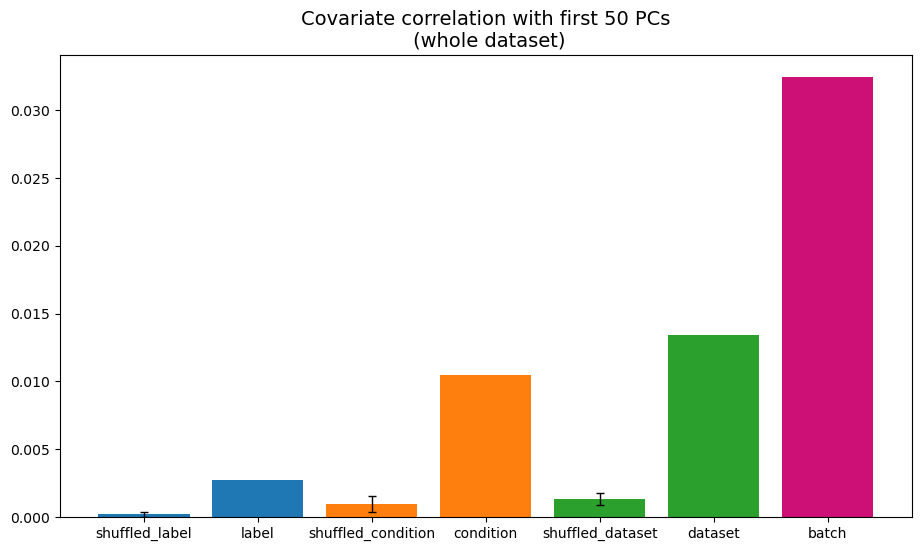

In [98]:
# Colors for the bars
colors = ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#2ca02c', '#2ca02c', '#CD1076']

# Plot
plt.figure(figsize=(7, 7))
rounded_values = df_sorted["fraction_of_variance_explained"]
x_values = np.arange(len(rounded_values))

# Draw bars and assign colors
plt.bar(x_values, rounded_values, color=colors)

# Add error bars
plt.errorbar(x_values, rounded_values, yerr=df_sorted["stdev"], fmt='none', ecolor='black', elinewidth=1, capsize=3)

plt.title("Covariate correlation with first 50 PCs\n (whole dataset)", fontsize=14)
plt.xticks(x_values, df_sorted["groupings"], rotation=0)
plt.gcf().set_size_inches(11,6)  # w = Breite, h = Höhe in Zoll
#plt.show()
plt.savefig(f"{dir_out}/results_integrated/batch_effect_final_plot.png", )